<a href="https://colab.research.google.com/github/leorr/AI/blob/main/Projeto_Deep_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

LINKS REFERÊNCIAS:

Classify Images Using Python & Machine Learning - https://www.youtube.com/watch?v=iGWbqhdjf2s

 CNN Com cachorros e gatos - https://machinelearningmastery.com/how-to-develop-a-convolutional-neural-network-to-classify-photos-of-dogs-and-cats/

 what-are-max-pooling-average-pooling-global-max-pooling https://github.com/christianversloot/machine-learning-articles/blob/main/what-are-max-pooling-average-pooling-global-max-pooling-and-global-average-pooling.md

 Global Max Pool https://www.tensorflow.org/api_docs/python/tf/keras/layers/GlobalMaxPool2D

Multiprocessing https://stackoverflow.com/questions/55531427/how-to-define-max-queue-size-workers-and-use-multiprocessing-in-keras-fit-gener

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras import layers
import os
import pandas as pd
import seaborn as sn

IMG_SIZE = 68


In [2]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    'Downloads/archive/afhq/train',
    validation_split=0.2,
    subset="training",
    label_mode='categorical',
    seed=123,
    shuffle=True,
    image_size=(IMG_SIZE,IMG_SIZE),
    batch_size=32)

val_ds = tf.keras.utils.image_dataset_from_directory(
  'Downloads/archive/afhq/train',
  validation_split=0.2,
  subset="validation",
  label_mode='categorical',
  seed=123,
  shuffle=True,
  image_size=(IMG_SIZE, IMG_SIZE),
  batch_size=32)

test_ds = tf.keras.utils.image_dataset_from_directory(
  'Downloads/archive/afhq/val',
  label_mode='categorical',
  shuffle=False,
  image_size=(IMG_SIZE, IMG_SIZE),
  batch_size=32)

class_names = train_ds.class_names
val_samples   = len(val_ds.file_paths)
train_samples = len(train_ds.file_paths)
test_samples  = len(test_ds.file_paths)

Found 14630 files belonging to 3 classes.
Using 11704 files for training.
Found 14630 files belonging to 3 classes.
Using 2926 files for validation.
Found 1500 files belonging to 3 classes.


In [3]:
#ex5 EfficientNetB0 por que era leve e tinha uma boa relação tempo por step x acuracia
base_model = tf.keras.applications.EfficientNetB0(weights='imagenet',
                                             include_top=False,
                                             input_shape=(IMG_SIZE,IMG_SIZE,3),
                                             pooling="max")

train_ds = tf.keras.applications.efficientnet.preprocess_input(train_ds)
val_ds   = tf.keras.applications.efficientnet.preprocess_input(val_ds)
test_ds = tf.keras.applications.efficientnet.preprocess_input(test_ds)

x=base_model.output
x=tf.keras.layers.Dropout(0.5)(x)
preds=tf.keras.layers.Dense(3, activation='softmax')(x)  #ex 4
model = tf.keras.models.Model(
    inputs=base_model.input,
    outputs=preds
)

for l in model.layers:
  if l.name.split('_')[0] != 'dense':
    l.trainable=False
  else:
    l.trainable=True

In [4]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 68, 68, 3)]  0           []                               
                                                                                                  
 rescaling (Rescaling)          (None, 68, 68, 3)    0           ['input_1[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 68, 68, 3)    7           ['rescaling[0][0]']              
                                                                                                  
 tf.math.truediv (TFOpLambda)   (None, 68, 68, 3)    0           ['normalization[0][0]']          
                                                                                              

In [5]:
#ex6
opt = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(
    optimizer=opt,
    loss='categorical_crossentropy',
    metrics=['accuracy'])

step_size_train=-(-train_samples//32)
step_size_val = -(-val_samples//32)

print("step_size_val=" + str(step_size_val) + " step_size_train="+ str(step_size_train))

#treinamento do modelo
history = model.fit(
    x=train_ds,
    steps_per_epoch=step_size_train,
    epochs=20,
    validation_data=val_ds,
    validation_steps=step_size_val)

step_size_val=92 step_size_train=366
Epoch 1/20
366/366 [==============================] - 62s 155ms/step - loss: 0.2853 - accuracy: 0.9064 - val_loss: 0.0745 - val_accuracy: 0.9727
Epoch 2/20
366/366 [==============================] - 57s 155ms/step - loss: 0.1377 - accuracy: 0.9562 - val_loss: 0.0576 - val_accuracy: 0.9802
Epoch 3/20
366/366 [==============================] - 57s 157ms/step - loss: 0.1141 - accuracy: 0.9622 - val_loss: 0.0597 - val_accuracy: 0.9781
Epoch 4/20
366/366 [==============================] - 57s 157ms/step - loss: 0.1036 - accuracy: 0.9653 - val_loss: 0.0583 - val_accuracy: 0.9809
Epoch 5/20
366/366 [==============================] - 58s 157ms/step - loss: 0.1129 - accuracy: 0.9633 - val_loss: 0.0565 - val_accuracy: 0.9812
Epoch 6/20
366/366 [==============================] - 58s 159ms/step - loss: 0.0989 - accuracy: 0.9673 - val_loss: 0.0514 - val_accuracy: 0.9846
Epoch 7/20
366/366 [==============================] - 58s 158ms/step - loss: 0.0987 - accurac

In [6]:

results = model.evaluate(test_ds)
print('Acc: %.3f, Loss: %.3f' % (results[1], results[0]))
print(history.history.keys())

47/47 [==============================] - 6s 122ms/step - loss: 0.0521 - accuracy: 0.9847
Acc: 0.985, Loss: 0.052
dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


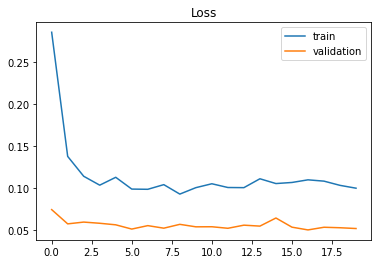

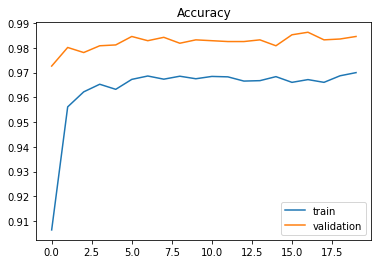

In [19]:
#ex7 - Analisando as perdas do modelo e a acurácia
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.legend()
plt.show()
print()
print()
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='validation')
plt.legend()
plt.show()

In [ ]:
#ex11
num_epochs      = len(history.history['val_loss'])
lr_value        = model.optimizer.get_config()['learning_rate']
base_model_name = base_model.name

final_name  = base_model_name + "_valSamples[" + str(val_samples) + "]"
final_name += "_train_sample[" + str(train_samples) + "]" + "_lr[" + str(lr_value).replace(".", "-") + "]" +"_num_epochs[" + str(num_epochs) + "]"

model.save(final_name)

INFO:tensorflow:Assets written to: efficientnetb0_valSamples[3226]_train_sample[12904]_lr[0-001]_num_epochs[500]\assets


INFO:tensorflow:Assets written to: efficientnetb0_valSamples[3226]_train_sample[12904]_lr[0-001]_num_epochs[500]\assets



> 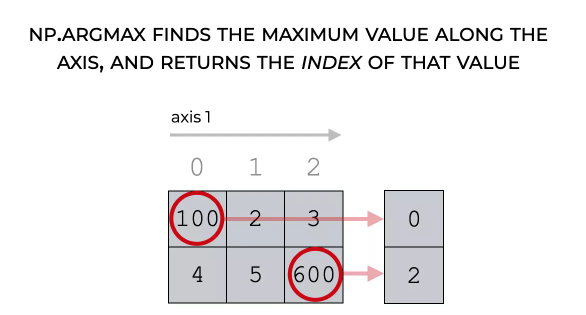



47/47 [==============================] - 7s 120ms/step
----------------CLASSIFICATION--------------
              precision    recall  f1-score   support

           0       0.99      0.98      0.99       503
           1       0.99      0.99      0.99       503
           2       0.98      0.99      0.98       494

    accuracy                           0.99      1500
   macro avg       0.99      0.99      0.99      1500
weighted avg       0.99      0.99      0.99      1500



<AxesSubplot:>

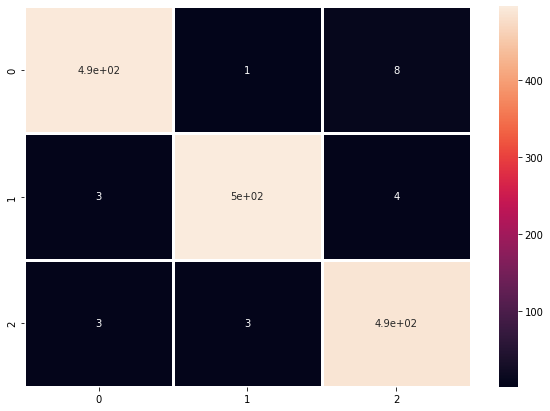

In [8]:
ytrue=[]
for images, label in test_ds:   
    for e in label:
        ytrue.append(e.numpy()>0.5)


preds=model.predict(test_ds) # predict on the test data
ypred = (preds > 0.5)

classification = classification_report(ypred.argmax(axis=1),np.argmax(ytrue,axis=1))
print('----------------CLASSIFICATION--------------')
print(classification)
matrix = confusion_matrix(ypred.argmax(axis=1),np.argmax(ytrue,axis=1))
df_cm = pd.DataFrame(matrix, index = [i for i in range(3)],
                  columns = [i for i in range(3)])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True, linewidths=2.5)

1/1 [==============================] - 0s 23ms/step


Text(0.5, 1.0, 'This image most likely belongs to dog with a 57.54 percent confidence.')

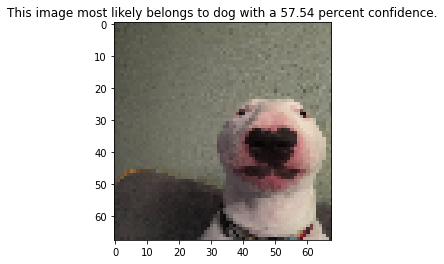

In [17]:
img = tf.keras.utils.load_img(
    'Downloads/test/1_rIkmavUeqyRySwlQdA9kKg.jpg', target_size=(IMG_SIZE,IMG_SIZE))

img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])
plt.imshow(img)
plt.title(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score)))